In [1]:
import kagglehub
import os
import pandas as pd

# Download latest version
path = kagglehub.dataset_download("raghadalharbi/breast-cancer-gene-expression-profiles-metabric")

print("Path to dataset files:", path)
df = pd.read_csv(os.path.join(path, "METABRIC_RNA_Mutation.csv"))

/mnt/d/Forschung/Breast-Cancer-Treatment-Prediction/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/kesslermatics/.cache/kagglehub/datasets/raghadalharbi/breast-cancer-gene-expression-profiles-metabric/versions/1


/tmp/ipykernel_36770/2461765115.py:9: DtypeWarning: Columns (678,688,690,692) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(path, "METABRIC_RNA_Mutation.csv"))


Epoch 1/200 | Train Loss: 1.0866 | Val Loss: 1.0550
Epoch 2/200 | Train Loss: 1.0568 | Val Loss: 1.0232
Epoch 3/200 | Train Loss: 1.0178 | Val Loss: 0.9918
Epoch 4/200 | Train Loss: 0.9928 | Val Loss: 0.9602
Epoch 5/200 | Train Loss: 0.9668 | Val Loss: 0.9285
Epoch 6/200 | Train Loss: 0.9428 | Val Loss: 0.8982
Epoch 7/200 | Train Loss: 0.8936 | Val Loss: 0.8683
Epoch 8/200 | Train Loss: 0.8956 | Val Loss: 0.8425
Epoch 9/200 | Train Loss: 0.9188 | Val Loss: 0.8210
Epoch 10/200 | Train Loss: 0.8512 | Val Loss: 0.7984
Epoch 11/200 | Train Loss: 0.8152 | Val Loss: 0.7735
Epoch 12/200 | Train Loss: 0.8156 | Val Loss: 0.7508
Epoch 13/200 | Train Loss: 0.7906 | Val Loss: 0.7309
Epoch 14/200 | Train Loss: 0.8208 | Val Loss: 0.7129
Epoch 15/200 | Train Loss: 0.7734 | Val Loss: 0.6972
Epoch 16/200 | Train Loss: 0.7618 | Val Loss: 0.6817
Epoch 17/200 | Train Loss: 0.7658 | Val Loss: 0.6667
Epoch 18/200 | Train Loss: 0.7595 | Val Loss: 0.6538
Epoch 19/200 | Train Loss: 0.7055 | Val Loss: 0.6413
Ep

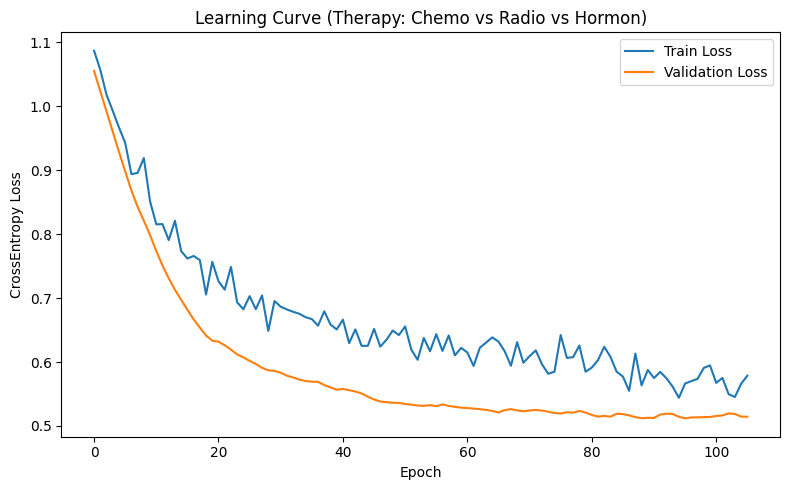

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cpu")

selected_features = [
    "age_at_diagnosis", "tumor_size", "tumor_stage", "lymph_nodes_examined_positive",
    "nottingham_prognostic_index", "cellularity", "neoplasm_histologic_grade",
    "inferred_menopausal_state", "er_status_measured_by_ihc", "pr_status", "her2_status"
]

df["therapy_class_simple"] = -1
df.loc[(df["chemotherapy"] == 1) & (df["hormone_therapy"] == 0) & (df["radio_therapy"] == 0), "therapy_class_simple"] = 0
df.loc[(df["chemotherapy"] == 0) & (df["hormone_therapy"] == 0) & (df["radio_therapy"] == 1), "therapy_class_simple"] = 1
df.loc[(df["chemotherapy"] == 0) & (df["hormone_therapy"] == 1) & (df["radio_therapy"] == 0), "therapy_class_simple"] = 2

df = df[df["therapy_class_simple"] != -1].copy()
df = df.dropna(subset=selected_features + ["therapy_class_simple"])
X = df[selected_features].copy()
y = df["therapy_class_simple"].astype(int)

categorical_cols = X.select_dtypes(include=["object", "bool", "category"]).columns.tolist()
X[categorical_cols] = X[categorical_cols].astype(str)
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_cols),
    ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_cols)
])
X_processed = preprocessor.fit_transform(X)
input_dim = X_processed.shape[1]
num_classes = len(np.unique(y))

X_tensor = torch.tensor(X_processed, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y.values, dtype=torch.long).to(device)

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, stratify=y, random_state=42)
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)

class MulticlassTherapyModel(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(16, out_dim)
        )

    def forward(self, x):
        return self.net(x)

model = MulticlassTherapyModel(input_dim, num_classes).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

best_val_loss = float("inf")
patience = 10
counter = 0
best_model_state = None

train_losses, val_losses = [], []
for epoch in range(200):
    model.train()
    epoch_loss = 0
    for xb, yb in train_loader:
        preds = model(xb)
        loss = loss_fn(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))

    model.eval()
    with torch.no_grad():
        val_preds = model(X_test)
        val_loss = loss_fn(val_preds, y_test)
        val_losses.append(val_loss.item())

    print(f"Epoch {epoch+1}/200 | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}")

    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        best_model_state = model.state_dict()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

if best_model_state is not None:
    model.load_state_dict(best_model_state)

os.makedirs("../outputs/figures", exist_ok=True)
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("CrossEntropy Loss")
plt.title("Learning Curve (Therapy: Chemo vs Radio vs Hormon)")
plt.legend()
plt.tight_layout()
plt.savefig("../outputs/figures/nn_learning_curve_therapy_simple.png")
plt.show()


              precision    recall  f1-score    support
0              1.000000  0.800000  0.888889   5.000000
1              0.818182  0.710526  0.760563  38.000000
2              0.755102  0.860465  0.804348  43.000000
accuracy       0.790698  0.790698  0.790698   0.790698
macro avg      0.857761  0.790330  0.817933  86.000000
weighted avg   0.797213  0.790698  0.789916  86.000000


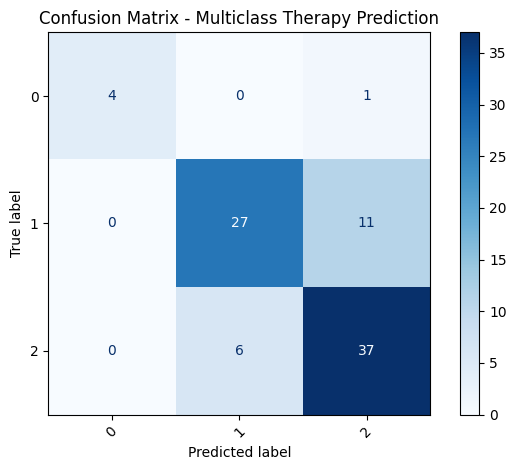

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import os
import pandas as pd

model.eval()
with torch.no_grad():
    logits = model(X_test)
    y_pred = torch.argmax(logits, dim=1).cpu().numpy()
    y_true = y_test.cpu().numpy()

report = classification_report(y_true, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

print(report_df)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix - Multiclass Therapy Prediction")
plt.tight_layout()
os.makedirs("../outputs/figures", exist_ok=True)
plt.savefig("../outputs/figures/confusion_matrix_multiclass_therapy.png")
plt.show()


In [14]:
import seaborn as sns

# Output directory
output_dir = "../outputs/figures/correlation"
os.makedirs(output_dir, exist_ok=True)

# Mapping class IDs to names
class_labels = {
    0: "Chemotherapy",
    1: "Radiotherapy",
    2: "Hormone therapy"
}

# Plot each feature against therapy class
for col in selected_features:
    plt.figure(figsize=(6, 4))

    if df[col].dtype == "object":
        sns.countplot(data=df, x=col, hue="therapy_class_simple")
        plt.xticks(rotation=45)
    else:
        sns.boxplot(data=df, x="therapy_class_simple", y=col)

    # Add legend with ID to therapy name
    legend_text = "\n".join([f"{k}: {v}" for k, v in class_labels.items()])
    plt.gcf().text(0.99, 0.5, legend_text, fontsize=9, va="center")

    plt.title(f"{col} vs. Therapy Class")
    plt.tight_layout()
    plt.savefig(f"{output_dir}/{col}_vs_therapy_class.png", bbox_inches="tight")
    plt.close()